<a href="https://colab.research.google.com/github/suebatista/hackathon/blob/main/dermatite_inss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DATATHON - DERMATITE ATÓPICA**#
Eretz.bio / Hospital Albert Einstein / Apoio: Abbvie <br>

**Grupo de trabalho:**<br>
DataDES

**Integrantes:** <br>
Danilo Gouvea Silva<br>
Eduardo R. Malaquias Chagas<br>
Suelen Cristina Batista da Silva

**Esse notebook responde a parte da PERGUNTA 3 referente aos benefícios do INSS**


##**PREPARAÇÃO DO NOTEBOOK E IMPORTAÇÃO DOS DATASETS**##

In [1]:
# Import libraries
from google.colab import files
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import graphing libraries
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Import data sets from Google Drive
# This only needs to be done once per notebook session

# '/datathon-dermatite/data/' Google Drive folder id 
data_id = '1TNeTdeTIez7hZZwOc0WsewaD_n3vzoGx'

# List folders under '/datathon-dermatite/data/'
folders = drive.ListFile({'q': "mimeType contains '.folder' and '{}' in parents".format(data_id)}).GetList()
for folder in folders:
    if 'inss' in folder['title']:
        Path.mkdir(Path() / 'data' / folder['title'], parents=True, exist_ok=True)
        files = drive.ListFile({'q': "title contains '.parquet' and '{}' in parents".format(folder['id'])}).GetList()
        for fn in files:
            # Download file
            fn_id = fn['id']
            fn_title = fn['title']
            downloaded = drive.CreateFile({'id': fn_id, 'title': fn_title})
            downloaded.GetContentFile(fn_title)

            # Move file to right folder
            filepath = Path().cwd() / fn_title
            Path(filepath).rename(Path().cwd() / 'data' / folder['title'] / fn_title)

            # Success message
            print(f'"{fn_title}" successfully imported to "./data/{folder["title"]}"')
  
# Success message
print('ALL FILES IMPORTED!')


"INSS_beneficios_indeferidos.parquet" successfully imported to "./data/inss_beneficios"
"INSS_beneficios_concedidos.parquet" successfully imported to "./data/inss_beneficios"
ALL FILES IMPORTED!


##**PERGUNTA 3**##
**Comparação com outros CIDs de doenças crônicas: L40 (psoríase) e L73.2 (hidradenite supurativa)**

###INSS - BENEFÍCIOS CONCEDIDOS###


In [4]:
# Create dataframe
file_path = Path('data/inss_beneficios/INSS_beneficios_concedidos.parquet')
df_concedidos = pd.read_parquet(file_path, engine='pyarrow')

In [5]:
df_concedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11631138 entries, 0 to 433675
Data columns (total 14 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Competência concessão  int64 
 1   Espécie                object
 2   CID                    object
 3   CID.1                  object
 4   Despacho               object
 5   Dt Nascimento          object
 6   Sexo.                  object
 7   Clientela              object
 8   Mun Resid              object
 9   Vínculo dependentes    object
 10  Forma Filiação         object
 11  UF                     object
 12  Qt SM RMI              object
 13  CID_1                  object
dtypes: int64(1), object(13)
memory usage: 1.3+ GB


In [6]:
df_concedidos.head(2)

,Competência concessão,Espécie,CID,CID.1,Despacho,Dt Nascimento,Sexo.,Clientela,Mun Resid,Vínculo dependentes,Forma Filiação,UF,Qt SM RMI,CID_1
0,201901,Auxílio Doenca Previdenciário,I83,I83 Varizes dos Membros Infer,Concessao Normal,25/10/1967,Feminino,Urbano,02003-AL-Arapiraca,Filho,Empregado,Alagoas,"1,068",None
1,201901,Auxílio Doenca Previdenciário,S525,S52.5 Frat da Extremidade Distal do Radio,Conc. Base Artigo 27 Inciso Ii do Rbps,16/05/1994,Masculino,Urbano,02003-AL-Arapiraca,Não Informado,Empregado,Alagoas,"1,099",None


In [7]:
df_concedidos['Dt Nascimento'] = pd.to_datetime(df_concedidos['Dt Nascimento'], infer_datetime_format=True, errors='coerce')
df_concedidos['ANO'] = df_concedidos['Competência concessão'] // 100
df_concedidos['MÊS'] = df_concedidos['Competência concessão'] % 100
df_concedidos['IDADE'] = df_concedidos['ANO'] - df_concedidos['Dt Nascimento'].dt.year
df_concedidos['CID_SHORT'] = df_concedidos.CID.str[:3]

In [8]:
# Create column 'FAIXA_ETARIA'
df_concedidos['FAIXA_ETARIA'] = np.nan
df_concedidos.FAIXA_ETARIA = pd.cut(df_concedidos.IDADE, [0, 5, 11, 17, 29, 49, 150], labels=['0-6', '6-12', '12-18', '18-30', '30-50', '50+'], include_lowest=True)

In [9]:
# Filter dataframe for all L20 and L40 CIDs and L732 specifically
df = df_concedidos[(df_concedidos.CID.str[:3].isin(['L20', 'L40'])) | (df_concedidos.CID == 'L732')]

In [10]:
df.head(2)

,Competência concessão,Espécie,CID,CID.1,Despacho,Dt Nascimento,Sexo.,Clientela,Mun Resid,Vínculo dependentes,Forma Filiação,UF,Qt SM RMI,CID_1,ANO,MÊS,IDADE,CID_SHORT,FAIXA_ETARIA
841,201901,Auxílio Doenca Previdenciário,L40,L40 Psoriase,Concessao Normal,1966-06-12,Masculino,Rural,04039-BA-Bom Jesus da Lapa,Não Informado,Segurado Especial,Bahia,"1,000",None,2019,1,53.0,L40,50+
2195,201901,Amp. Social Pessoa Portadora Deficiencia,L209,L20.9 Dermatite Atopica Ne,Concessao Normal,2005-10-20,Masculino,Urbano,05043-CE-Crato,Não Informado,Desempregado,Ceará,"1,000",None,2019,1,14.0,L20,12-18


**3.1 Quantos benefícios solicitados e concedidos comparativamente entre as doenças?**

In [32]:
cids = df[df.ANO != 2021].groupby(['ANO', 'CID_SHORT']).agg(
    CID=pd.NamedAgg('CID.1', 'first'),
    NUM_BENEFICIOS=pd.NamedAgg('CID_SHORT', 'count')
).sort_values(['ANO', 'NUM_BENEFICIOS'], ascending=[True, False])

cids['PORCENTAGEM'] = np.NaN

for year in cids.reset_index().ANO.unique():
  total = cids.loc[year].NUM_BENEFICIOS.sum()
  cids.loc[year, 'PORCENTAGEM'] = round(cids.NUM_BENEFICIOS / total * 100, 1)

cids[['NUM_BENEFICIOS','PORCENTAGEM']]

NUM_BENEFICIOS  PORCENTAGEM
ANO  CID_SHORT                             
2019 L40                  1378         69.5
     L20                   303         15.3
     L73                   303         15.3
2020 L40                   466         69.2
     L73                   111         16.5
     L20                    96         14.3

In [25]:
mask_cids=cids.reset_index().replace({'CID_SHORT' : { 'L20' : 'Dermatite atópica', 'L40' : 'Psoríase', 'L73' : 'Hidradenite Supurativa' }})

In [ ]:
px.bar(mask_cids.reset_index(),x='ANO',y='NUM_BENEFICIOS',color='CID_SHORT',title= 'Quantos benefícios solicitados e concedidos comparativamente entre as doenças?',barmode='group')

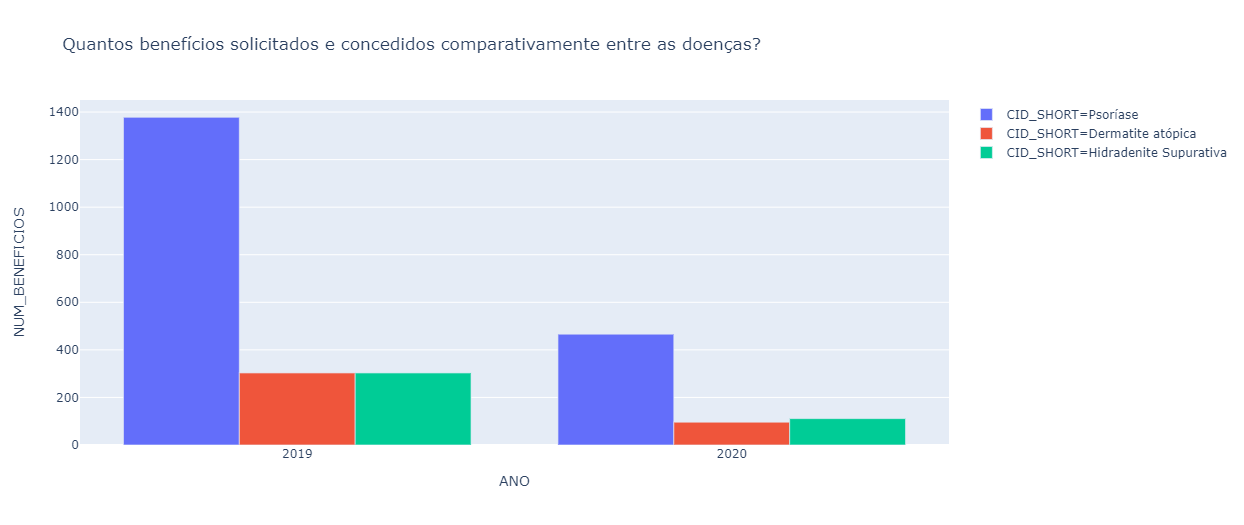

**3.2 Qual a faixa etária que mais solicita em cada uma das doenças?**


In [14]:
age_groups = df[df.ANO != 2021].groupby(['CID_SHORT', 'FAIXA_ETARIA']).agg(
    NUM_BENEFICIOS=pd.NamedAgg('FAIXA_ETARIA', 'count')
).sort_values(['CID_SHORT', 'NUM_BENEFICIOS'], ascending=[True, False])

age_groups['PORCENTAGEM'] = np.NaN

for cid in age_groups.reset_index().CID_SHORT.unique():
  total = age_groups.loc[cid].NUM_BENEFICIOS.sum()
  age_groups.loc[cid, 'PORCENTAGEM'] = round(age_groups.NUM_BENEFICIOS / total * 100, 1)

age_groups

NUM_BENEFICIOS  PORCENTAGEM
CID_SHORT FAIXA_ETARIA                             
L20       30-50                    180         45.1
          50+                      107         26.8
          18-30                     88         22.1
          0-6                       13          3.3
          6-12                       9          2.3
          12-18                      2          0.5
L40       50+                      879         47.7
          30-50                    853         46.3
          18-30                    103          5.6
          6-12                       7          0.4
          0-6                        1          0.1
          12-18                      1          0.1
L73       30-50                    251         60.6
          18-30                    106         25.6
          50+                       57         13.8
          0-6                        0          0.0
          6-12                       0          0.0
          12-18                      0          0.0

In [15]:
mask=age_groups.reset_index().replace({'CID_SHORT' : { 'L20' : 'Dermatite atópica', 'L40' : 'Psoríase', 'L73' : 'Hidradenite Supurativa' }})

In [ ]:
fig = px.bar(mask.reset_index(),x='CID_SHORT',y='NUM_BENEFICIOS',color='FAIXA_ETARIA',title='Qual a faixa etária que mais solicita benefícios em cada uma das doenças?',barmode="group",labels={
                     'FAIXA_ETARIA': "Faixa etária",
                     'NUM_BENEFICIOS': "Número de benefícios",
                     'CID_SHORT': "CID"
                 })


fig.show()

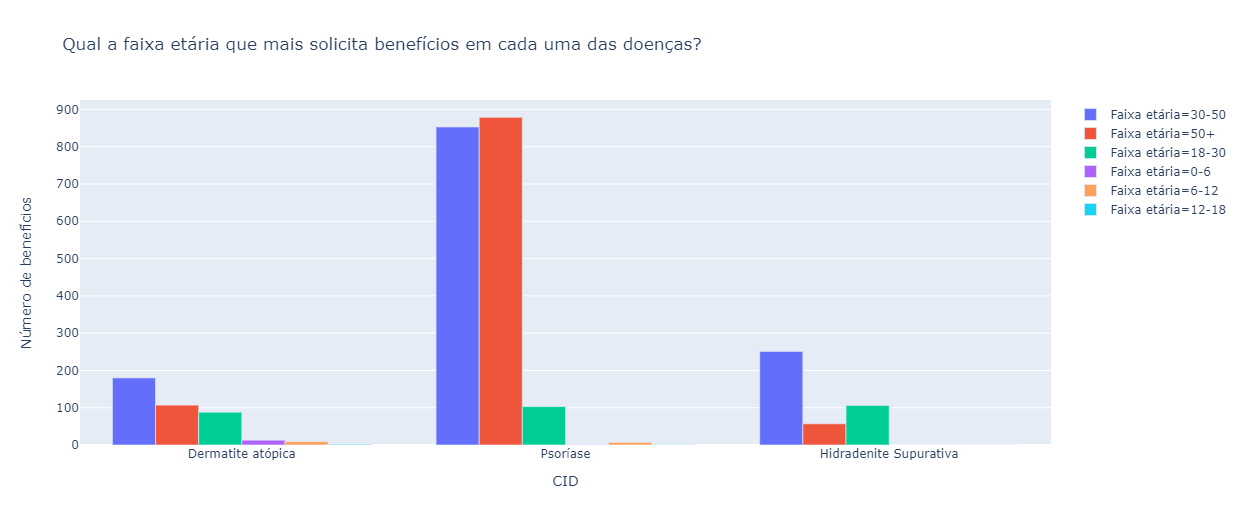

**3.3 Quais tipos de benefícios mais solicitados e mais concedidos?**

In [17]:
benefits = df[df.ANO != 2021].groupby(['CID_SHORT', 'Espécie']).agg(
    NUM_BENEFICIOS=pd.NamedAgg('CID_SHORT', 'count')
).sort_values(['CID_SHORT', 'NUM_BENEFICIOS'], ascending=[True, False])

benefits['PORCENTAGEM'] = np.NaN

for cid in benefits.reset_index().CID_SHORT.unique():
  total = benefits.loc[cid].NUM_BENEFICIOS.sum()
  benefits.loc[cid, 'PORCENTAGEM'] = round(benefits.NUM_BENEFICIOS / total * 100, 1)

benefits

NUM_BENEFICIOS  PORCENTAGEM
CID_SHORT Espécie                                                              
L20       Auxílio Doenca Previdenciário                        350         87.7
          Amp. Social Pessoa Portadora Deficiencia              30          7.5
          Aposentadoria Invalidez Previdenciária                 9          2.3
          Auxílio Doenca por Acidente do Trabalho                9          2.3
          Aposent. Invalidez Acidente Trabalho                   1          0.3
L40       Auxílio Doenca Previdenciário                       1559         84.5
          Aposentadoria Invalidez Previdenciária               208         11.3
          Amp. Social Pessoa Portadora Deficiencia              71          3.9
          Auxílio Doenca por Acidente do Trabalho                5          0.3
          Aposent. Invalidez Acidente Trabalho                   1          0.1
L73       Auxílio Doenca Previdenciário                        383         92.5
          Aposentadoria Invalidez Previdenciária                28          6.8
          Amp. Social Pessoa Portadora Deficiencia               3          0.7

In [18]:
mask_benefits=benefits.reset_index().replace({'CID_SHORT' : { 'L20' : 'Dermatite atópica', 'L40' : 'Psoríase', 'L73' : 'Hidradenite Supurativa' }})

In [ ]:
px.bar(mask_benefits.reset_index(),x='CID_SHORT',y='NUM_BENEFICIOS',color='Espécie',barmode='group',title='Quais tipos de benefícios mais solicitados e mais concedidos?')

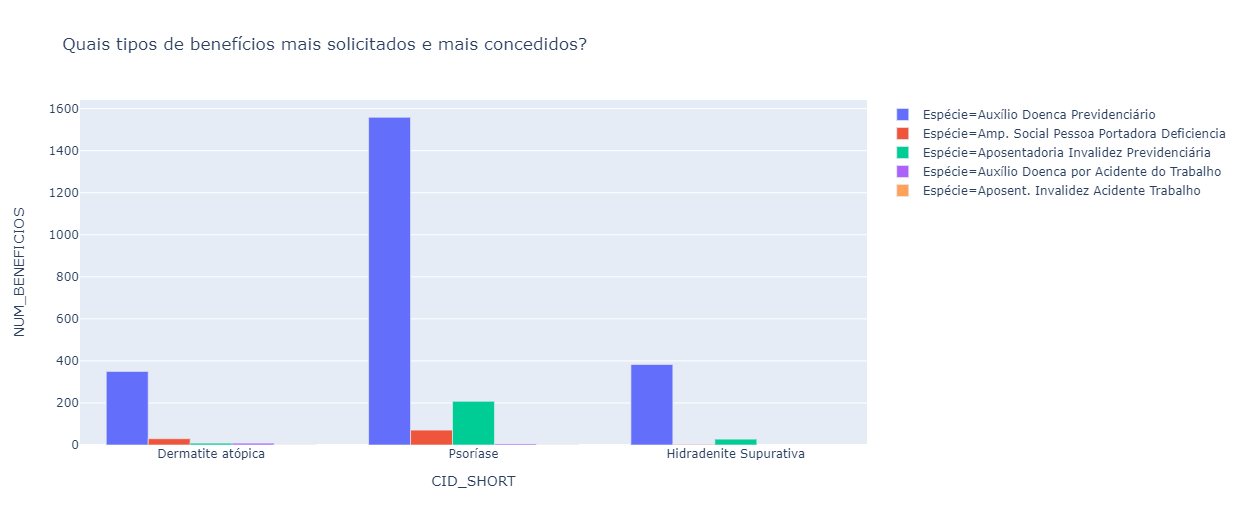

### INSS - BENEFÍCIOS INDEFERIDOS###
**Não há nenhum campo na tabela de benefícios indeferidos que possa relacionar o registro com o tipo/CID de doença. Logo, infelizmente, não é possível gerar conhecimento sobre benefícios indeferidos que foram solicitados devido ao CID de Dermatite Atópica ou outros doenças crônicas de pele**

In [21]:
# Create dataframe
file_path = Path('data/inss_beneficios/INSS_beneficios_indeferidos.parquet')
df_indeferidos = pd.read_parquet(file_path, engine='pyarrow')

In [22]:
df_indeferidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274832 entries, 0 to 373459
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   Competência indeferimento  object
 1   Espécie                    object
 2   Motivo Indeferimento       object
 3   Dt Nascimento              object
 4   Sexo.                      object
 5   Clientela                  object
 6   Forma Filiação             object
 7   UF                         object
 8   Dt Indeferimento           object
dtypes: object(9)
memory usage: 783.9+ MB


In [23]:
df_indeferidos.head()

,Competência indeferimento,Espécie,Motivo Indeferimento,Dt Nascimento,Sexo.,Clientela,Forma Filiação,UF,Dt Indeferimento
0,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,02/05/1963,Feminino,Urbano,Desempregado,Alagoas,02/01/2019
1,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,12/07/1967,Masculino,Urbano,Desempregado,Alagoas,02/01/2019
2,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,01/01/1966,Masculino,Urbano,Desempregado,Alagoas,02/01/2019
3,201901,Auxílio Salario Maternidade,Parto/Guarda para Fins Adocao sem Qualidade de...,03/03/1978,Feminino,Urbano,Doméstico,Alagoas,04/01/2019
4,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,04/02/1966,Masculino,Urbano,Desempregado,Alagoas,04/01/2019
